In [985]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline

pd.set_option('precision', 3)
pd.set_option('max_rows', 100)

In [986]:
def transform_df(df):
    
    def get_title(row):
        step1 = row['Name'].split(',', 1)
        step2 = step1[1].split('.', 1)
    
        return step2[0].strip()

    def family_size(row):
        if row['SibSp'] == 0 and row['Parch'] == 0:
            return 0
        else:
            return row['SibSp'] + row['Parch'] + 1
        
    ticket_dict = df['Ticket'].value_counts()

    def get_same_ticket(ticket, dictionary):
        return dictionary[ticket]
    
    def is_royalty(row):
        if row['Title'] in ['Lady', 'Sir', 'Jonkheer', 'the Countess']:
            return 1
        else:
            return 0
        
    def is_officer(row):
        if row['Title'] in ['Col', 'Major', 'Capt', 'Dr', 'Rev'] or row['Crew'] == 1:
            return 1
        else:
            return 0
        
    def fill_by(df, feature, by, value):
        '''
        fill df[feature] by specific value in df[by]
        '''
        index = df[(df[by] == value) & (df[feature].isnull() == True)].index
        mean  = df[df[by] == value][feature].mean()
        df.loc[index,feature] = mean
        
    def get_deck(code):
        if isinstance(code, str):
            return code[0]
        
    def is_crew(row):
        if row['Fare'] == 0:
            return 1
        else:
            return 0
        
    def group_titles(x):
        vocab = {
            'Rev'          : 'Mr',
            'Don'          : 'Mr',
            'Ms'           : 'Miss',
            'Mlle'         : 'Miss',
            'Dona'         : 'Miss',
            'Mme'          : 'Miss',
            'Col'          : 'Mr',
            'Major'        : 'Mr',
            'Jonkheer'     : 'Mr',
            'Capt'         : 'Mr',
            'the Countess' : 'Mrs',
            'Lady'         : 'Miss',
            'Sir'          : 'Mr'
        }
        
        if x in vocab.keys():
            return vocab[x]
        else:
            return x
        
    def identify_child(df):
        index = df[(df['Family Size'] > 3) & (df['Parch'] < df['SibSp']) & (df['Parch'] > 1)]
    
    df['Title']       = df.apply(lambda x: get_title(x), axis=1)
    df['Group Size']  = df['Ticket'].apply(lambda x: get_same_ticket(x, ticket_dict))
    df['Family Size'] = df.apply(lambda x: family_size(x), axis=1)
    df['Royalty']     = df.apply(lambda x: is_royalty(x), axis=1)
    df.loc[:,'Fare']  = df.loc[:,'Fare'] / df.loc[:,'Group Size']
    df['Crew']        = df.apply(lambda x: is_crew(x), axis=1)
    df['Officer']     = df.apply(lambda x: is_officer(x), axis=1)
    df['Title']       = df['Title'].apply(lambda x: group_titles(x))
      
    fill_by(df, 'Age', 'Title', 'Master')
    fill_by(df, 'Age', 'Title', 'Dr')
    fill_by(df, 'Age', 'Crew', 1)
    fill_by(df, 'Age', 'Title', 'Mrs')

    df['Age'].fillna(df.groupby(['Pclass', 'Sex'])['Age'].transform("mean"), inplace=True)
    
    df['Age Group'] = pd.cut(df['Age'], [0,12,19,30,55,65,105], include_lowest=True, right=False, labels=False)

In [987]:
def ml_ready(df):
    from sklearn.cross_validation import train_test_split
    
    features = ['Age Group', 'Sex', 'Family Size', 'Pclass']
    target   = 'Survived'
    
    X = df[features]
    y = df[target]
    
    for column in X.columns:
        if column != 'Age':
            X.loc[:,column], junk = X.loc[:,column].factorize()

    return train_test_split(X, y, test_size=0.3, random_state=379582)

def infer_ready(df):
    features = ['Age Group', 'Sex', 'Family Size', 'Pclass']
    
    X = df[features]
    
    for column in X.columns:
        if column != 'Age':
            X.loc[:,column], junk = X.loc[:,column].factorize()
    
    return X

def train_and_evaluate(X_train, X_test, y_train, y_test, infer):

    from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
    from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    from sklearn.model_selection import GridSearchCV

    gboost = GradientBoostingClassifier(n_estimators=60, learning_rate=0.09)

    gboost.fit(X_train, y_train)

    #predictions = gboost.predict(X_test)
    predictions = gboost.predict_proba(X_test)[:,1] > 0.572
    predictions_prob = gboost.predict_proba(X_test)

    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    print('\n' + str(roc_auc_score(y_test, predictions_prob[:,1])))
    
    fpr, tpr, thresholds = roc_curve(y_test, predictions_prob[:,1])
    
    plt.figure(figsize=(16,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr,tpr, label='AUC = %0.4f'% roc_auc_score(y_test, predictions_prob[:,1]))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='upper left')
    
    def acc(row, y_true, y_score):
        threshold = row['Threshold']
        return accuracy_score(y_true, y_score > threshold)
    
    def prec(row, y_true, y_score):
        threshold = row['Threshold']
        return precision_score(y_true, y_score > threshold)
    
    def rec(row, y_true, y_score):
        threshold = row['Threshold']
        return recall_score(y_true, y_score > threshold)
    
    summary = pd.DataFrame(index=range(0,len(fpr)))
    summary.loc[:,'FPR'] = fpr
    summary.loc[:,'TPR'] = tpr
    summary.loc[:,'Threshold'] = thresholds
    summary['Accuracy'] = summary.apply(lambda x: acc(x,y_test,predictions_prob[:,1]), axis=1)
    summary['Precision'] = summary.apply(lambda x: prec(x,y_test,predictions_prob[:,1]), axis=1)
    summary['Recall'] = summary.apply(lambda x: rec(x,y_test,predictions_prob[:,1]), axis=1)
    
    submissions = gboost.predict(infer)
    
    submission = pd.DataFrame(index=infer.index)
    submission['Survived'] = submissions
    submission['Survived'] = submission['Survived'].astype('int32')
    
    submission.to_csv('submission-04.csv')
    
    return summary

In [988]:
train_csv = pd.read_csv('../input/train.csv')
infer_csv = pd.read_csv('../input/test.csv')

In [989]:
train_csv.set_index('PassengerId', inplace=True)
infer_csv.set_index('PassengerId', inplace=True)
df = pd.concat([train_csv, infer_csv], axis=0, sort=False)

In [990]:
transform_df(df)

In [1009]:
df[(df['Parch'] <= df['SibSp']) & (df['Parch'] > 1)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Group Size,Family Size,Royalty,Crew,Officer,Age Group
PassengerId,,,,,,,,,,,,,,,,,,
28,0.0,1,"Fortune, Mr. Charles Alexander",male,19.000,3,2,19950,43.833,C23 C25 C27,S,Mr,6,6,0,0,0,2
60,0.0,3,"Goodwin, Master. William Frederick",male,11.000,5,2,CA 2144,5.862,NaN,S,Master,8,8,0,0,0,0
64,0.0,3,"Skoog, Master. Harald",male,4.000,3,2,347088,4.650,NaN,S,Master,6,6,0,0,0,0
69,1.0,3,"Andersson, Miss. Erna Alexandra",female,17.000,4,2,3101281,7.925,NaN,S,Miss,1,7,0,0,0,1
72,0.0,3,"Goodwin, Miss. Lillian Amy",female,16.000,5,2,CA 2144,5.862,NaN,S,Miss,8,8,0,0,0,1
89,1.0,1,"Fortune, Miss. Mabel Helen",female,23.000,3,2,19950,43.833,C23 C25 C27,S,Miss,6,6,0,0,0,2
120,0.0,3,"Andersson, Miss. Ellis Anna Maria",female,2.000,4,2,347082,4.468,NaN,S,Miss,7,7,0,0,0,0
148,0.0,3,"Ford, Miss. Robina Maggie ""Ruby""",female,9.000,2,2,W./C. 6608,6.875,NaN,S,Miss,5,5,0,0,0,0
160,0.0,3,"Sage, Master. Thomas Henry",male,5.483,8,2,CA. 2343,6.323,NaN,S,Master,11,11,0,0,0,0


In [992]:
index1 = df[df['Survived'].isnull() == False].index
index2 = df[df['Survived'].isnull() == True].index

train_csv = df.loc[index1,:]
infer_csv = df.loc[index2,:]

In [993]:
X_train, X_test, y_train, y_test = ml_ready(train_csv)
X = infer_ready(infer_csv)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


             precision    recall  f1-score   support

        0.0       0.82      0.90      0.86       162
        1.0       0.81      0.70      0.75       106

avg / total       0.82      0.82      0.81       268

[[145  17]
 [ 32  74]]

0.863353133007221


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


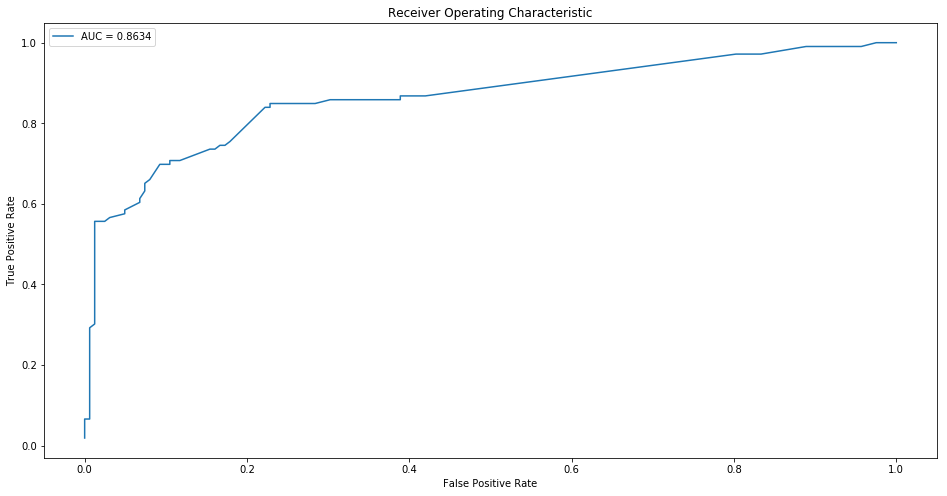

In [994]:
summary = train_and_evaluate(X_train, X_test, y_train, y_test, X)

In [995]:
max_acc = summary['Accuracy'].max()
summary[summary['Accuracy'] == max_acc]

,FPR,TPR,Threshold,Accuracy,Precision,Recall
29,0.105,0.698,0.572,0.825,0.831,0.698


In [996]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

params = {
    'n_estimators'      : [35,40,45,55,60,65,75],
    'learning_rate'     : [0.09,0.1,0.11],
    'max_depth'         : [3],
    'subsample'         : [1.0],
    'min_samples_split' : [2],
    'min_samples_leaf'  : [1],
    'max_features'      : [None]
}

model = GradientBoostingClassifier(random_state=379582)

grid = GridSearchCV(
    model, 
    params,
    scoring='accuracy',
    iid=False,
    cv=5
)
grid.fit(X_train, y_train)

grid.grid_scores_, grid.best_params_, grid.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.81233, std: 0.03390, params: {'learning_rate': 0.09, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 35, 'subsample': 1.0},
  mean: 0.81233, std: 0.03390, params: {'learning_rate': 0.09, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40, 'subsample': 1.0},
  mean: 0.81713, std: 0.03573, params: {'learning_rate': 0.09, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 45, 'subsample': 1.0},
  mean: 0.81874, std: 0.04148, params: {'learning_rate': 0.09, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 55, 'subsample': 1.0},
  mean: 0.82194, std: 0.03791, params: {'learning_rate': 0.09, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 60, 'subsample': 1.0},
  mean: 0.82194, std: 0.03791, params: {'learning_rate': 0.09, 'm